In [1]:
import tensorflow as tf
import numpy as np
from gbica_utils import *
from tf_powersfa import *

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
n_out = 3

In [3]:
N = 1000

encoding_x = tf.placeholder("float", [N,3])

Wx  = tf.Variable(tf.random_normal(stddev=0.1,shape=[3, n_out]))
b0   = tf.Variable(tf.constant(0.1,shape=[n_out]))

dense0 = tf.matmul(encoding_x, Wx) + b0
dense = alt_power_whitening(dense0, 3, 50)[0]

In [4]:
n_hidden = 32

y1, y2, y3 = tf.split(dense, 3, axis=1)

In [5]:
x1 = tf.concat([y2, y3], axis=1)
y_1 = permute_y(y1, N)

h_join1 = tf.concat([y1, x1], axis=1)
h_marg1 = tf.concat([y_1, x1], axis=1)

Wx1  = tf.Variable(tf.random_normal(stddev=0.1,shape=[3, n_hidden]))
b1   = tf.Variable(tf.constant(0.1,shape=[n_hidden]))

Wx2  = tf.Variable(tf.random_normal(stddev=0.1,shape=[n_hidden, n_hidden]))
b2   = tf.Variable(tf.constant(0.1,shape=[n_hidden]))

Wx3  = tf.Variable(tf.random_normal(stddev=0.1,shape=[n_hidden, n_hidden]))
b3   = tf.Variable(tf.constant(0.1,shape=[n_hidden]))

Wx4  = tf.Variable(tf.random_normal(stddev=0.1,shape=[n_hidden, n_hidden]))
b4   = tf.Variable(tf.constant(0.1,shape=[n_hidden]))

Wx5  = tf.Variable(tf.random_normal(stddev=0.1,shape=[n_hidden, n_hidden]))
b5   = tf.Variable(tf.constant(0.1,shape=[1]))

Wx6  = tf.Variable(tf.random_normal(stddev=0.1,shape=[n_hidden, n_hidden]))
b6   = tf.Variable(tf.constant(0.1,shape=[1]))

Wx7  = tf.Variable(tf.random_normal(stddev=0.1,shape=[n_hidden, 1]))
b7   = tf.Variable(tf.constant(0.1,shape=[1]))


def estimator_net_merge(h_join, h_marg):
    dense1_joint = tf.nn.leaky_relu(tf.matmul(h_join, Wx1) + b1)
    dense2_joint = tf.nn.leaky_relu(tf.matmul(dense1_joint, Wx2) + b2)
    dense3_joint = tf.nn.leaky_relu(tf.matmul(dense2_joint, Wx3) + b3)
    dense4_joint = tf.nn.leaky_relu(tf.matmul(dense3_joint, Wx4) + b4)
    dense5_joint = tf.nn.leaky_relu(tf.matmul(dense4_joint, Wx5) + b5)
    dense6_joint = tf.nn.leaky_relu(tf.matmul(dense5_joint, Wx6) + b6)
    dense7_joint = tf.matmul(dense6_joint, Wx7) + b7
    
    dense1_marg = tf.nn.leaky_relu(tf.matmul(h_marg, Wx1) + b1)
    dense2_marg = tf.nn.leaky_relu(tf.matmul(dense1_marg, Wx2) + b2)
    dense3_marg = tf.nn.leaky_relu(tf.matmul(dense2_marg, Wx3) + b3)
    dense4_marg = tf.nn.leaky_relu(tf.matmul(dense3_marg, Wx4) + b4)
    dense5_marg = tf.nn.leaky_relu(tf.matmul(dense4_marg, Wx5) + b5)
    dense6_marg = tf.nn.leaky_relu(tf.matmul(dense5_marg, Wx6) + b6)
    dense7_marg = tf.matmul(dense6_marg, Wx7) + b7
    
    return dense7_joint, dense7_marg

dense7_joint, dense7_marg = estimator_net_merge(h_join1, h_marg1)

loss1 = tf.reduce_mean(dense7_joint)-tf.log(tf.reduce_mean(tf.exp(dense7_marg)))

In [6]:
x2 = tf.concat([y1, y3], axis=1)
y_2 = permute_y(y2, N)

h_join2 = tf.concat([y2, x2], axis=1)
h_marg2 = tf.concat([y_2, x2], axis=1)

dense7_joint2, dense7_marg2 = estimator_net_merge(h_join2, h_marg2)

loss2 = tf.reduce_mean(dense7_joint2)-tf.log(tf.reduce_mean(tf.exp(dense7_marg2)))

In [7]:
x3 = tf.concat([y1, y2], axis=1)
y_3 = permute_y(y3, N)

h_join3 = tf.concat([y3, x3], axis=1)
h_marg3 = tf.concat([y_3, x3], axis=1)

dense7_joint3, dense7_marg3 = estimator_net_merge(h_join3, h_marg3)

loss3 = tf.reduce_mean(dense7_joint3)-tf.log(tf.reduce_mean(tf.exp(dense7_marg3)))

In [8]:
estimator_loss = -(loss1+loss2+loss3)

total_encoder_loss = loss1+loss2+loss3
encoder_lr = 0.005

train_encoders = tf.train.AdamOptimizer(encoder_lr).minimize(total_encoder_loss, var_list=[Wx, b0])
estimator_vars = [Wx1,  b1,  Wx2,  b2,  Wx3,  b3,  Wx4,  b4,  Wx5,  b5,  Wx6,  b6, Wx7, b7]

regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)

for var in estimator_vars:
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, var)
reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
estimator_loss += reg_term
train_estimators =  tf.contrib.opt.NadamOptimizer(0.005).minimize(estimator_loss, var_list=estimator_vars) 

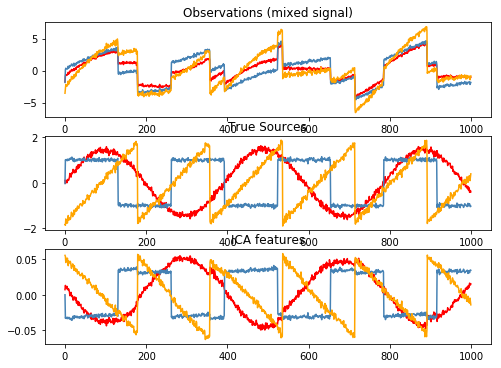

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA
from scipy import signal

time = np.linspace(0, 8, N)

s1 = np.sin(2 * time)                       # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))              # Signal 2 : square signal
s3 = signal.sawtooth(1.4 * np.pi * time)    # Signal 3 : saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.05 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1  , 1, 1],
              [0.5, 2, 1.0],
              [1.5, 1.0, 2.0]])  # Mixing matrixX = np.dot(S, A.T)  # Generate observations
X = np.dot(S, A.T)  # Generate observations

# Solve the task with FastICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals


models = [X, S, S_]
names = ['Observations (mixed signal)', 'True Sources', 'ICA features']
colors = ['red', 'steelblue', "orange"]
plt.figure(figsize=(8, 8))
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.show()

In [10]:
shuffled_x = np.array(X)


step: 0, loss1: -5.2e-05, loss2: 4.9e-05, loss3: 4.3e-05, all_loss: 3.9e-05


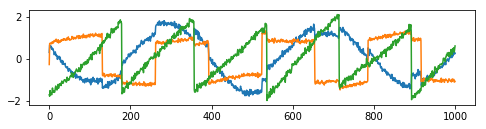

step: 100, loss1: 0.012, loss2: 0.0045, loss3: 0.015, all_loss: 0.031
step: 200, loss1: 0.2, loss2: 0.037, loss3: 0.21, all_loss: 0.45
step: 300, loss1: 0.086, loss2: 0.072, loss3: 0.15, all_loss: 0.31
step: 400, loss1: 0.12, loss2: 0.2, loss3: 0.19, all_loss: 0.52


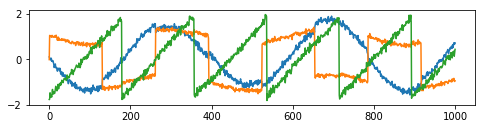

step: 500, loss1: -0.27, loss2: -0.25, loss3: -0.18, all_loss: -0.7
step: 600, loss1: 0.27, loss2: 0.37, loss3: 0.19, all_loss: 0.84
step: 700, loss1: 0.15, loss2: 0.18, loss3: 0.15, all_loss: 0.48
step: 800, loss1: 0.29, loss2: 0.35, loss3: 0.096, all_loss: 0.74


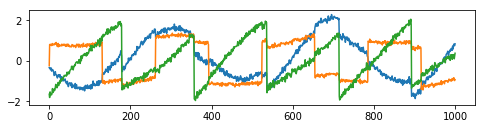

step: 900, loss1: 0.17, loss2: 0.024, loss3: -0.012, all_loss: 0.18
step: 1000, loss1: -0.016, loss2: 0.056, loss3: -0.071, all_loss: -0.031
step: 1100, loss1: 0.27, loss2: 0.37, loss3: 0.25, all_loss: 0.89
step: 1200, loss1: 0.26, loss2: 0.25, loss3: 0.38, all_loss: 0.89


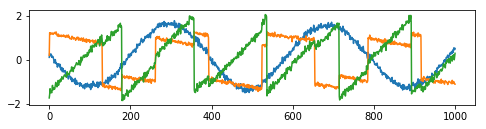

step: 1300, loss1: 0.29, loss2: 0.44, loss3: 0.29, all_loss: 1.0
step: 1400, loss1: 0.23, loss2: 0.45, loss3: 0.35, all_loss: 1.0
step: 1500, loss1: 0.29, loss2: 0.45, loss3: 0.29, all_loss: 1.0
step: 1600, loss1: 0.31, loss2: 0.089, loss3: 0.29, all_loss: 0.69


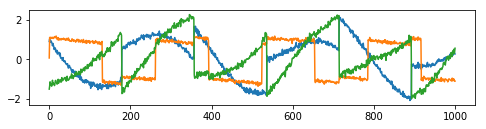

step: 1700, loss1: 0.44, loss2: 0.58, loss3: 0.34, all_loss: 1.4
step: 1800, loss1: 0.44, loss2: 0.58, loss3: 0.36, all_loss: 1.4
step: 1900, loss1: 0.32, loss2: 0.29, loss3: 0.2, all_loss: 0.81
step: 2000, loss1: 0.22, loss2: 0.12, loss3: 0.11, all_loss: 0.45


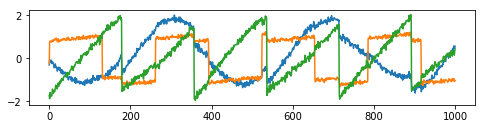

step: 2100, loss1: 0.34, loss2: 0.22, loss3: 0.29, all_loss: 0.85
step: 2200, loss1: 0.09, loss2: 0.055, loss3: 0.045, all_loss: 0.19
step: 2300, loss1: 0.28, loss2: 0.12, loss3: 0.28, all_loss: 0.68
step: 2400, loss1: 0.35, loss2: 0.22, loss3: 0.39, all_loss: 0.96


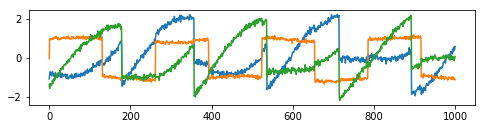

step: 2500, loss1: -0.98, loss2: -1.0, loss3: -0.85, all_loss: -2.9
step: 2600, loss1: 0.49, loss2: 0.14, loss3: 0.45, all_loss: 1.1
step: 2700, loss1: 0.58, loss2: 0.43, loss3: 0.58, all_loss: 1.6
step: 2800, loss1: 0.56, loss2: 0.38, loss3: 0.65, all_loss: 1.6


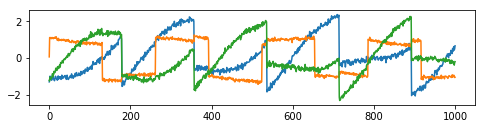

step: 2900, loss1: -0.34, loss2: -0.35, loss3: -0.27, all_loss: -0.96
step: 3000, loss1: 0.45, loss2: 0.61, loss3: 0.39, all_loss: 1.4
step: 3100, loss1: 0.36, loss2: 0.64, loss3: 0.29, all_loss: 1.3
step: 3200, loss1: 0.3, loss2: 0.23, loss3: 0.31, all_loss: 0.84


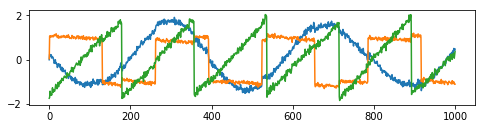

step: 3300, loss1: 0.27, loss2: 0.33, loss3: 0.35, all_loss: 0.95
step: 3400, loss1: 0.28, loss2: 0.42, loss3: 0.3, all_loss: 1.0
step: 3500, loss1: 0.32, loss2: 0.5, loss3: 0.3, all_loss: 1.1
step: 3600, loss1: 0.44, loss2: 0.49, loss3: 0.35, all_loss: 1.3


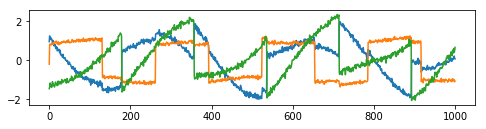

step: 3700, loss1: 0.34, loss2: 0.52, loss3: 0.48, all_loss: 1.3
step: 3800, loss1: 0.3, loss2: 0.28, loss3: 0.44, all_loss: 1.0
step: 3900, loss1: 0.13, loss2: 0.49, loss3: 0.35, all_loss: 0.97
step: 4000, loss1: 0.23, loss2: 0.37, loss3: 0.19, all_loss: 0.79


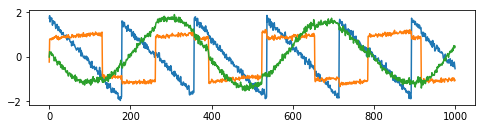

In [11]:
from random import shuffle
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(4001):
        np.random.shuffle(shuffled_x)
        current_loss1, current_loss2, current_loss3, _ = sess.run([loss1,
                                                    loss2, loss3, train_estimators], feed_dict={encoding_x:X})

        if i % 7   is 0: 
            _ = sess.run(train_encoders, feed_dict={encoding_x:X})

        if i % 100 is 0: 
            print("step: {}, loss1: {:.2}, loss2: {:.2}, loss3: {:.2}, all_loss: {:.2}".format(i,
                                current_loss1, current_loss2, current_loss3, current_loss1+current_loss2+current_loss3))
        if i % 400 is 0:
            plt.figure(figsize=(8, 8))
            plt.subplot(4, 1, 1)
            encoding = sess.run(dense, feed_dict={encoding_x:X})
            plt.plot(encoding)
            plt.show()